# Web scraping Bourbon reviews

[Distiller.com](https://distiller.com/) is a site with reviews of various drinks. We pick Bourbon by searching it to get this url (https://distiller.com/search?term=bourbon) and then scrape info from it.

In [55]:
import re
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import sleep
import seaborn as sns
sns.set()

In [649]:
url = 'https://distiller.com/spirits/eagle-rare-10-year'
page = requests.get(url)
bs = BeautifulSoup(page.content, "html.parser")

### Accessing tags and the class 

In [81]:
# finds all with this tag
bs.find_all('h2')

# finds all with tags in list
bs.find_all(['h2', 'h1'])

# get the third tag data
bs.find_all('h2')[2]

# get the contents in this
bs.find_all('h2')[2].contents

bs.find_all(['h2', 'h1'])

[<h2 class="primary-text">
 It looks like we got out of sync.
 <br/>
 Reload your page to freshen up and ensure that you get the best experience.
 </h2>,
 <h1 class="secondary-headline name" data-behavior="truncatable" itemprop="name">
 Eagle Rare 10 Year Bourbon
 </h1>,
 <h2 class="ultra-mini-headline type">Bourbon</h2>,
 <h2 class="ultra-mini-headline location middleweight" content="Eagle Rare" itemprop="brand_name">
 Eagle Rare // Kentucky, USA
 </h2>,
 <h2 class="label mini-headline">community rating</h2>,
 <h2 class="mini-headline">Tasting Notes</h2>]

In [136]:
# find the tag and class in that tag
bs.find('h1', class_ = "secondary-headline name")

<h1 class="secondary-headline name" data-behavior="truncatable" itemprop="name">
Eagle Rare 10 Year Bourbon
</h1>

In [137]:
# get only the text
bs.find('h1', class_ = "secondary-headline name").text.strip()

'Eagle Rare 10 Year Bourbon'

In [380]:
# drink type
bs.find('h2', class_ = "ultra-mini-headline type").text.strip()

'Bourbon'

In [693]:
# Get rating
bs.find('div', class_ = 'stats').find_all('span')[0].text
bs.find('span', attrs={'itemprop': "ratingValue"}).text.strip()

'3.66'

In [177]:
# get Age
bs.find('ul', class_ = "other-details").find('li', class_ = 'detail age').find('div', class_ = 'value').text[:-5]

'10'

In [632]:
# get Cost

a = bs.find('ul', class_ = "other-details").find('li', class_ = 'detail cost').find('div', class_ = 'value')
re.findall("(\d)", str(a))

bs.find('ul', class_ = "other-details").find('li', class_ = 'detail cost').find('div', class_ = 'value')


<div class="value">
<div class="spirit-cost cost-2" data-behavior="cost-value">
<i class="fa fa-dollar"></i>
<i class="fa fa-dollar"></i>
<i class="fa fa-dollar"></i>
<i class="fa fa-dollar"></i>
<i class="fa fa-dollar"></i>
</div>
</div>

In [239]:
# ABV
bs.find('ul', class_ = "other-details").find('li', class_ = 'detail abv').find('div', class_ = 'value').text

'45.0'

In [264]:
# Style
bs.find('ul', class_ = "other-details").find('li', class_ = 'detail whiskey-style').find('div', class_ = 'value').text.strip()

'Produced anywhere in USA; Mash bill of at least 51% corn; aged in new, charred oak containers.'

In [269]:
# cask type
bs.find('ul', class_ = "other-details").find('li', class_ = 'detail cask-type').find('div', class_ = 'value').text.strip()

'new, charred American oak'

In [280]:
# flavor summary
bs.find('div', class_ = "flavor-profile").find('h3', class_ = "secondary-headline flavors middleweight").text

'Sweet & Full Bodied'

### Get attributes, convert str to dict, extract values

In [319]:
# flavor details

# get the attributes 
bs.find('div', class_ = "flavor-profile").find('canvas').attrs

{'class': ['js-flavor-profile-chart'],
 'data-flavors': '{"smoky":5,"peaty":0,"spicy":30,"herbal":5,"oily":0,"full_bodied":70,"rich":65,"sweet":80,"briny":0,"salty":0,"vanilla":40,"tart":0,"fruity":40,"floral":10}',
 'height': '250',
 'width': '900'}

In [327]:
# this gives a string which can be converted into a dictionary
bs.find('div', class_ = "flavor-profile").find('canvas').attrs['data-flavors']

'{"smoky":5,"peaty":0,"spicy":30,"herbal":5,"oily":0,"full_bodied":70,"rich":65,"sweet":80,"briny":0,"salty":0,"vanilla":40,"tart":0,"fruity":40,"floral":10}'

In [328]:
a = bs.find('div', class_ = "flavor-profile").find('canvas').attrs['data-flavors']
a = eval(a)
a

{'smoky': 5,
 'peaty': 0,
 'spicy': 30,
 'herbal': 5,
 'oily': 0,
 'full_bodied': 70,
 'rich': 65,
 'sweet': 80,
 'briny': 0,
 'salty': 0,
 'vanilla': 40,
 'tart': 0,
 'fruity': 40,
 'floral': 10}

In [589]:
bs.find('div', class_ = "content").find('p').attrs['itemprop']
bs.find('div', class_ = "content").find('div', class_ = "meet-experts").find('a').text.strip()
bs.find('div', class_ = "content").find('div', class_ = "distiller-score").find('span').text

bs.find('div', class_ = "content").find('p').text


'"Eagle Rare 10 Year Bourbon is one of the great bourbon bargains out there, tasting way more expensive than it is. Its complexity starts with fruit flavors of dark cherries, red apples and bananas. Then the spices of cinnamon, clove and allspice kick in. These are rounded by honey, caramel, milk chocolate, vanilla and toasty oak. A rugged leather note rides it off into the sunset."'

### Code to extract all the links of boubon from the search page
1. First for loop goes through all the pages in the search pages of bourbon, requests the page, gets content via beautiful soup, and then fins all the links in each of the pages 
2. The second block saves all the links in ```whiskey_urls.txt``` file
3. The next block uses all the urls and beautiful soup to get the contents of each of the pages and writes the html in the local folder
4. Last block for case when all files have been downloaded. If yes, then it opens the txt file to read all the urls

In [111]:
# if not downloaded yet, then set to True and scrape the data
download_data = False
download_data = True

whiskey_urls = set()

if download_data:
    
    for page_num in range(1, 100):         # get 100 search pages = 1000 bourbon types

            # get the page for each search page of bourbon
            cur_page = requests.get('https://distiller.com/search?page=' + str(page_num) + '&term=bourbon')

            # uses BeautifulSoup to extract all links to whiskeys --- each page has 10 links for different whiskeys
            bs_page = BeautifulSoup(cur_page.content, "html.parser")
            for link in bs_page.findAll('a', attrs={'href': re.compile("^/spirits/")}):
                whiskey_urls.add(link.get('href'))

            # track progress    
            if page_num%10 == 0:
                print("page num:", page_num)
            
                
    # saves each URL to disk, so that we don't have to crawl the search results again
    f = open("./data/web_scraping/whiskey_urls.txt", "w")
    for url in whiskey_urls:
        f.write(url + "\n")
    f.close()
    
    # fetches each page and saves it to the hard drive
    for i, url in enumerate(whiskey_urls):
        cur_page = requests.get('https://distiller.com' + url).content

        # writes file
        f = open("./data/web_scraping/" + url[9:-1], 'wb')
        f.write(cur_page)
        f.close()

        # sleeps between 1-3 seconds, in case the site tries to detect crawling
        sleep(random.randint(1,3))

        if i%50 == 0: print(i)   # for trackin status
    

else:
    # if files   
    # open the text file with the links and use beautiful soup to extract the contents of each
    with open("./data/web_scraping/whiskey_urls.txt") as f:
        whiskey_urls = f.readlines()
        f.close()


page num: 10
page num: 20
page num: 30
page num: 40
page num: 50
page num: 60
page num: 70
page num: 80
page num: 90
0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [113]:
#whiskey_urls

## Function to get the urls of the Bourbon pages
- Go to the search page to get a list of the bourbons, inspect the page, and find the tag corresponding to the link

In [203]:
# use this block to check the code below

url1 = 'https://distiller.com/spirits/eagle-rare-10-year'
url2 = 'https://distiller.com/spirits/woodford-reserve-bourbon'
url3 = 'https://distiller.com/spirits/camp-1805-surveyors-bourbon-barreled-rum'
url4 = 'https://distiller.com/spirits/rhum-barbancourt-cuvee-150-ans'
url5 = 'https://distiller.com/spirits/breuckelen-77-straight-bourbon-whiskey-single-barrel-the-prime-bourbon-breaking-bourbon'

whiskey_urls = [url1, url2, url3, url4, url5]

In [78]:
# use this if you want all the urls
with open("./data/whiskey_urls.txt") as f:
        whiskey_urls = f.readlines()
        f.close()
    

## Function to get the data from the site or local folder and store in data frame

In [114]:

whiskey_values = []
whiskey = {}


for i, url in enumerate(whiskey_urls):
    
    # check progress
    if i%50 == 0: print(i) 
      
    #####
    # This is to be used only to check with the five urls from previous chunk
    #page = requests.get(url)
    #bs = BeautifulSoup(page.content, "html.parser")    
    ######
    
    # Read the files that have been downloaded from the site
    file = "./data/web_scraping" + url[8:-1]  
    
    with open(file, errors = "ignore") as fp:
        bs = BeautifulSoup(fp, 'html.parser')
    
    
    
    # initialize a few in case of missing values
    rating = "N/A"
    num_rating = 0
    abv = ""
    style = ""
    cask = ""
    flavor_profile = ""
    flavor_dict = {}
    price = ""
    review = ""
    
    # extract various elements from the source page
    name = bs.find('h1', class_ = re.compile("secondary-headline name")).text.strip()
    type_w = bs.find('li', attrs={'class': "detail whiskey-style"}).div.text
    location = bs.find('h2', class_ = "ultra-mini-headline location middleweight").text.strip()
    
    # next block ...check if ratingCount is not zero
    if bs.find('span', itemprop = "ratingCount") != None:
        rating = float(bs.find('span', attrs={'itemprop': "ratingValue"}).text.strip())
        num_rating = int(bs.find('span', itemprop = "ratingCount").text.strip())
    
    # next block
    age = bs.find('ul', class_ = "other-details").find('li', class_ = 'detail age').find('div', class_ = 'value').text
    
    # get the info belonging to the class, convert to string, and then extract the digit
    price_class = bs.find('ul', class_ = "other-details").find('li', class_ = 'detail cost').find('div', class_ = 'value')
    price = re.findall("(\d)", str(price_class))[0]
    
    abv = bs.find('ul', class_ = "other-details").find('li', class_ = 'detail abv').find('div', class_ = 'value').text
    style = bs.find('ul', class_ = "other-details").find('li', class_ = 'detail whiskey-style').find('div', class_ = 'value').text.strip()
    
    
    if bs.find('li', class_ = 'detail cask-type') != None:
        cask = bs.find('li', class_ = 'detail cask-type').find('div', class_ = 'value').text.strip()
    
    
    # check if an expert has reviewed it
    if bs.find('p', itemprop = 'reviewBody') != None:
        #review = bs.find('p', itemprop = 'reviewBody').text
        expert = bs.find('div', class_ = 'meet-experts').find('a').text.strip()
        score = bs.find('div', class_ = "distiller-score").find('span').text
        
        # get flavor profile and 
        flavor_summary = bs.find('div', class_ = "flavor-profile").find('h3', class_ = "secondary-headline flavors middleweight").text
        flavor_dict = eval(bs.find('div', class_ = "flavor-profile").find('canvas').attrs['data-flavors'])
        
    ####
              
    # store the values 
    whiskey_values = [name, type_w, location, rating, num_rating, age, price, abv, style, 
                      cask, flavor_summary, expert, score]
    
    
    # check if flavor_dict has values... if yes, add them to whiskey_values, else add zeros
    if flavor_dict:
        whiskey_values.extend(list(flavor_dict.values()))
    else:
        whiskey_values.extend(np.zeros(14))
    
    # create col names and add the names from the flavor dictionary keys
    columns = ['name', 'type', 'location', 'rating', 'num_ratings', 'age', 'price', 'abv', 'style', 
               'cask', 'flavor_summary', 'expert', 'score',
               'Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',
                 'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral']
    
    
    # stor the values in a dictonary with keys as   
    whiskey[i] = whiskey_values
    
    df = pd.DataFrame.from_dict(whiskey, orient = 'index', columns = columns)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


### Get contents from local file
Code to check whether I can read each of the url and parse the data. I encountered one error which I fixed by adding ```encoding = 'utg8'``` and/or ```errors = 'ignore'```

https://stackoverflow.com/questions/9233027/unicodedecodeerror-charmap-codec-cant-decode-byte-x-in-position-y-character


In [33]:
# to get contents from local file

# https://stackoverflow.com/questions/21570780/using-python-and-beautifulsoup-saved-webpage-source-codes-into-a-local-file

for i, url in enumerate(whiskey_urls):
    
    # just run only 10 urls and check
          
    file = "./data/web_scraping" + url[8:-1]  

    with open(file, errors = "ignore") as fp:
        bs = BeautifulSoup(fp, 'html.parser')



## Review and clean dataframe

In [748]:
#df.to_csv('./data/bourbon.csv')
df = pd.read_csv('./data/bourbon.csv', index_col = 0)

In [749]:
df['rating'] = pd.to_numeric(df['rating'], errors = "coerce")
df['price'] = pd.to_numeric(df['price'], errors = "coerce")
df['abv'] = pd.to_numeric(df['abv'], errors = "coerce")
df['score'] = pd.to_numeric(df['score'], errors = "coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958 entries, 0 to 957
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            958 non-null    object 
 1   type            958 non-null    object 
 2   location        958 non-null    object 
 3   rating          921 non-null    float64
 4   num_ratings     958 non-null    int64  
 5   age             911 non-null    object 
 6   price           958 non-null    int64  
 7   abv             953 non-null    float64
 8   style           958 non-null    object 
 9   cask            889 non-null    object 
 10  flavor_summary  958 non-null    object 
 11  expert          958 non-null    object 
 12  score           958 non-null    int64  
 13  Smoky           958 non-null    float64
 14  Peaty           958 non-null    float64
 15  Spicy           958 non-null    float64
 16  Herbal          958 non-null    float64
 17  Oily            958 non-null    flo

In [119]:
df.head()

,name,type,location,rating,num_ratings,age,price,abv,style,cask,...,Oily,Full-bodied,Rich,Sweet,Briny,Salty,Vanilla,Tart,Fruity,Floral
0,Rock Town Straight Bottled in Bond Bourbon,Bourbon,"Rock Town // Arkansas, USA",3.50,3,4 Year,3,50.00,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,George T. Stagg Bourbon (Fall 2018),Bourbon,"George T. Stagg // Kentucky, USA",4.59,420,NAS,4,62.45,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak",...,20.0,90.0,70.0,60.0,0.0,0.0,90.0,10.0,20.0,0.0
2,Happenstance Founder's Edition Straight Bourbon,Bourbon,Happenstance Whiskey // Indiana (bottled in Te...,NaN,0,NAS,3,45.00,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak",...,5.0,75.0,70.0,60.0,0.0,0.0,25.0,20.0,40.0,0.0
3,Wild Turkey Rare Breed Barrel Proof Bourbon,Bourbon,"Wild Turkey // Kentucky, USA",4.11,2198,NAS,2,58.40,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak",...,0.0,90.0,80.0,70.0,0.0,0.0,90.0,20.0,10.0,10.0
4,Temperance Trader Chinato Barrel-Finished Bourbon,Bourbon,Temperance Trader // Indiana (bottled in Orego...,3.68,9,NAS,2,45.00,Produced anywhere in USA; Mash bill of at leas...,"new, charred American oak; finished in ex-chin...",...,10.0,30.0,10.0,50.0,0.0,0.0,60.0,10.0,80.0,30.0


In [750]:
# lets analyze only Bourbon
df = df.loc[df['type'] == "Bourbon"]
df.type.value_counts()

Bourbon    913
Name: type, dtype: int64

### Cleaning the age column

In [751]:
# set NaN values of age to 0
df['age'] = df['age'].fillna('0')

In [752]:
# Let's clean the age and convert to int
#df.info()

# Number of rows with no age value
len(df[(df['age'] == "NAS") | (df['age'] == "nas") | (df['age'] == "")])


535

In [753]:
# replace those NAS, nas, null, with 0 and impute with some value later
df['age'] = df['age'].replace(['NAS', 'nas', 'N/A','', 'NAS '],'0')

In [288]:
# remove "Years" from the age

# regex to entire column 
# https://stackoverflow.com/questions/53962844/applying-regex-across-entire-column-of-a-dataframe
# * picks zero or more occurances of different types of YEAR
#df['age'] = [re.sub(" [Yy]ear[sS]*", "", x) for x in df['age']]

In [754]:
# extract digit from those with YR, Y info
df['age'] = [re.sub("[Yy].*", '', x) for x in df['age']]


In [755]:
# save temp copy of changes till now
df_copy = df.copy()

In [756]:
# extract number of months from those with months in it and replace one by one

#df[df['age'].str.contains("month")]['age']

df['age'] = df['age'].replace(to_replace ='18 - 20 [Mm]onths', value = '1.5', regex = True)
df['age'] = df['age'].replace(to_replace ='12 [Mm]onths', value = '1', regex = True)
df['age'] = df['age'].replace(to_replace ='19 [Mm]onths', value = '1.5', regex = True)
df['age'] = df['age'].replace(to_replace ='4 [Mm]onths', value = '0.3', regex = True)
df['age'] = df['age'].replace(to_replace ='9 to 11 ', value = '10', regex = True)
df['age'] = df['age'].replace(to_replace ='9 [Mm]onths', value = '0.3', regex = True)
df['age'] = df['age'].replace(to_replace ='Varies', value = '0', regex = True)
df['age'] = df['age'].replace(to_replace ='Varies by Batch', value = '0', regex = True)
df['age'] = df['age'].replace(to_replace ='6-8 ', value = '7', regex = True)
df['age'] = df['age'].replace(to_replace ='0 b', value = '0', regex = True)


#df[df['age'].str.contains("month")]['age'];


In [757]:
# change to float
df['age'] = df['age'].astype(float)

avg age of non zeros Bourbons is  9.944333333333335


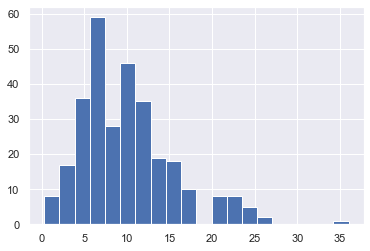

In [758]:
plt.hist(df.age[df.age > 0] , bins = 20);

print("avg age of non zeros Bourbons is ", df.age[df.age > 0].mean())

In [766]:
# impute the 0s to avg value of 10
df.age = df.age.replace(0, 10)

count    913.000000
mean       9.981709
std        3.159410
min        0.300000
25%       10.000000
50%       10.000000
75%       10.000000
max       36.000000
Name: age, dtype: float64

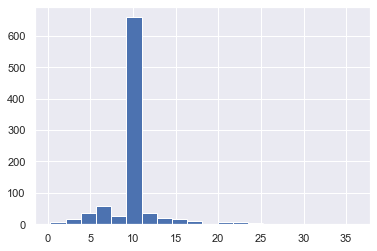

In [767]:
plt.hist(df.age, bins = 20);
df.age.describe()

### Ratings

In [782]:
print("Number of ratings with Nan:", sum(df.rating.isnull()))

# lets remove those rows
df = df[df.rating.isnull() == False]

Number of ratings with Nan: 0


### ABV

In [787]:
print("Number of abv % with Nan:", sum(df.abv.isnull()))

# lets remove those rows
df = df[df.abv.isnull() == False]

Number of abv % with Nan: 5


### Top Flavors and Experts

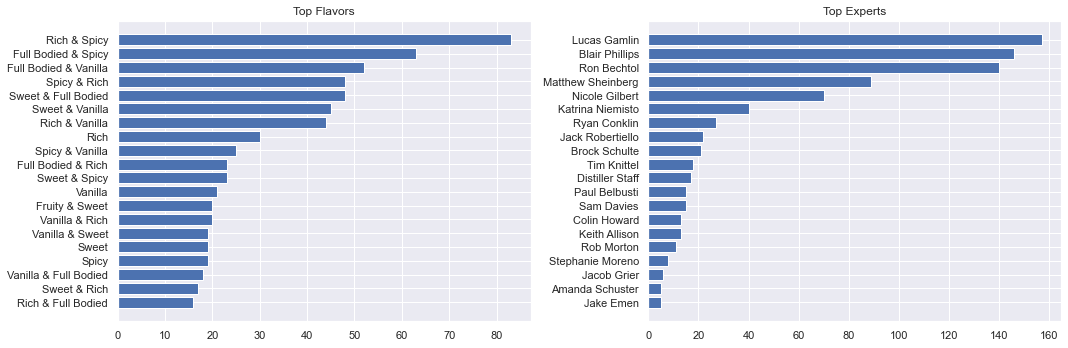

In [837]:
plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
top_flavors = df['flavor_summary'].value_counts()[:20]
plt.barh(top_flavors.index, top_flavors.sort_values())
plt.title("Top Flavors")

plt.subplot(1,2,2)
top_experts = df['expert'].value_counts()[:20]
plt.barh(top_experts.index, top_experts.sort_values())
plt.title("Top Experts")

plt.tight_layout()


### Top bourbon by customer review
Looks like those with high ratings from customers have high scores by experts and are 10 or more years old, but do not have very may ratings (< 10 ratings)

In [851]:
df.sort_values(by = "rating", ascending = False)[:20][["name", "rating", "score","num_ratings", "age", "price", "abv"]]

,name,rating,score,num_ratings,age,price,abv
657,Bear Wallow Single Barrel Straight Bourbon Whi...,5.00,92,2,4.0,3,62.00
339,O.F.C. Vintage Bourbon 1995,5.00,88,3,10.0,5,45.00
526,Still Austin Double Barreled Bourbon,5.00,79,1,10.0,4,54.50
764,O.F.C. Vintage Bourbon 1995,5.00,90,3,10.0,5,45.00
488,O.F.C. Vintage Bourbon 1995,5.00,92,3,10.0,5,45.00
461,Double Eagle Very Rare Bourbon,4.95,87,7,20.0,5,45.00
252,William Larue Weller Bourbon (Fall 2010),4.90,85,5,12.0,5,63.30
58,William Larue Weller Bourbon (Fall 2010),4.90,98,5,12.0,5,63.30
269,William Larue Weller Bourbon (Fall 2010),4.90,90,5,12.0,5,63.30
50,William Larue Weller Bourbon (Fall 2010),4.90,93,5,12.0,5,63.30


### Top bourbon by experts
High scores by experts have very large number of reviews and these bourbons are much older in age

In [857]:
df.sort_values(by = "score", ascending = False)[:10][["name", "rating", "score","num_ratings", "age", "price", "abv"]]

,name,rating,score,num_ratings,age,price,abv
58,William Larue Weller Bourbon (Fall 2010),4.90,98,5,12.0,5,63.30
618,Four Roses Limited Edition Single Barrel Bourb...,4.26,98,509,11.0,4,54.20
239,Four Roses Limited Edition Single Barrel Bourb...,4.23,98,159,13.0,5,59.80
57,"Booker's Bourbon Batch 2015-01 ""Big Man, Small...",4.37,98,712,7.0,3,64.35
31,"Bookerâ€™s Bourbon Batch 2021-01 ""Donohoe's Ba...",4.35,97,84,6.0,4,62.65
32,Kirkland Small Batch Bourbon 7 Year,3.17,97,144,7.0,1,51.50
342,Wild Turkey Diamond Anniversary Bourbon,4.33,97,297,10.0,4,45.50
943,Black Maple Hill 16 Year Bourbon,4.62,97,69,16.0,4,47.50
887,Eagle Rare 17 Year Bourbon (Fall 2015),4.38,96,94,17.0,3,45.00
256,Eagle Rare 17 Year Bourbon (Fall 2014),4.32,96,182,17.0,3,45.00


### Oldest and most popular

In [856]:
df.sort_values(by = "age", ascending = False)[:10][["name", "rating", "score","num_ratings", "age", "price", "abv"]]

,name,rating,score,num_ratings,age,price,abv
597,Heaven Hill 27 Year Barrel Proof Kentucky Stra...,4.33,93,35,27.0,5,47.35
206,Old Blowhard 26 Year Bourbon,3.71,81,79,26.0,5,45.35
225,Michter's 25 Year Kentucky Straight Bourbon (2...,4.10,91,5,25.0,5,58.65
486,Rhetoric 25 Year Bourbon,4.33,91,139,25.0,4,45.50
416,Michter's 25 Year Single Barrel Bourbon,4.56,87,22,25.0,5,54.30
766,Parkerâ€™s Heritage Bottled-in-Bond Bourbon 24...,4.34,91,75,24.0,5,50.00
475,Rhetoric 24 Year Bourbon,4.21,89,144,24.0,4,45.40
152,Rhetoric 23 Year Bourbon,4.19,85,141,23.0,4,45.30
813,Evan Williams 23 Year Bourbon,4.38,86,39,23.0,5,53.50
378,Elijah Craig 23 Year Bourbon,4.19,90,176,23.0,5,45.00


In [855]:
df.sort_values(by = "num_ratings", ascending = False)[:10][["name", "rating", "score","num_ratings", "age", "price", "abv"]]

,name,rating,score,num_ratings,age,price,abv
178,Buffalo Trace Bourbon,3.68,83,10821,10.0,2,45.0
609,Eagle Rare 10 Year Bourbon,4.03,91,10145,10.0,2,45.0
746,Woodford Reserve Bourbon,3.66,85,8189,10.0,2,45.2
439,Maker's Mark Bourbon,3.46,87,8073,10.0,2,45.0
957,Bulleit Bourbon,3.48,86,7571,10.0,2,45.0
402,Four Roses Single Barrel Bourbon,4.00,90,6793,10.0,2,50.0
800,Basil Hayden's Bourbon,3.62,80,6246,10.0,2,40.0
322,Weller Special Reserve Bourbon,3.89,91,6034,10.0,2,45.0
807,Angel's Envy Bourbon Finished in Port Wine Bar...,3.86,84,5626,10.0,2,43.3
306,Elijah Craig Small Batch Bourbon,3.68,85,5527,10.0,2,47.0


### Locations

In [859]:
df.location.value_counts()[:10]

Booker's // Kentucky, USA                 29
Four Roses // Kentucky, USA               20
Old Forester // Kentucky, USA             18
Elijah Craig // Kentucky, USA             15
Bardstown Bourbon Co. // Kentucky, USA    13
Heaven Hill // Kentucky, USA              13
Michter's // Kentucky, USA                12
Angel's Envy // Kentucky, USA             11
Kentucky Owl // Kentucky, USA             11
Buffalo Trace // Kentucky, USA            11
Name: location, dtype: int64

### Flavor distribution

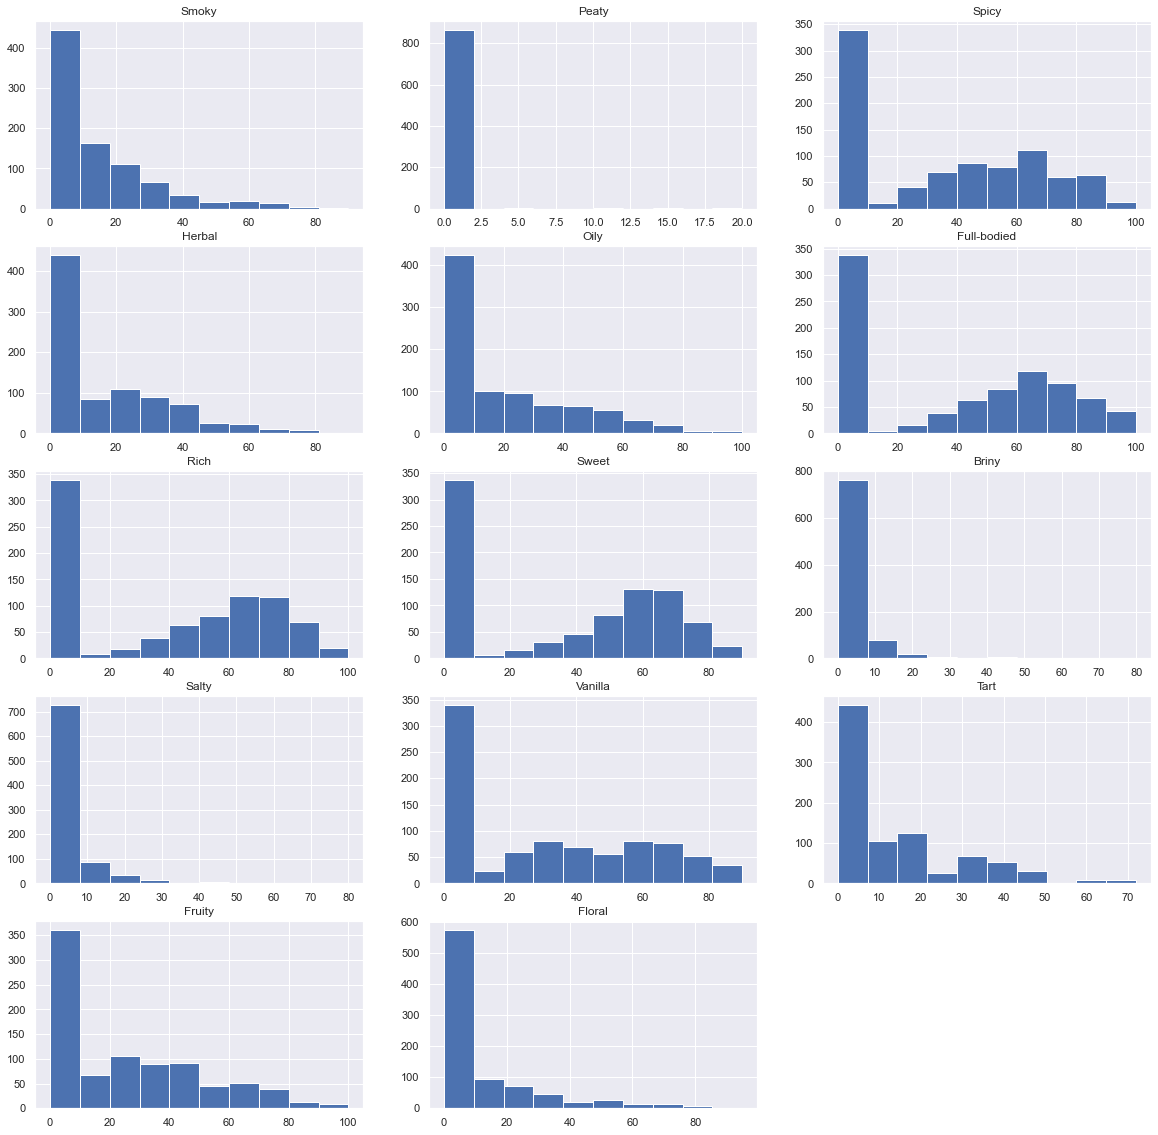

In [881]:
flavors = ['Smoky', 'Peaty', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',\
        'Sweet', 'Briny', 'Salty', 'Vanilla', 'Tart', 'Fruity', 'Floral']


plt.figure(figsize = (20,20))
for i, f in enumerate(flavors):
    plt.subplot(5,3,i+1)
    plt.hist(df[f])
    plt.title(f)

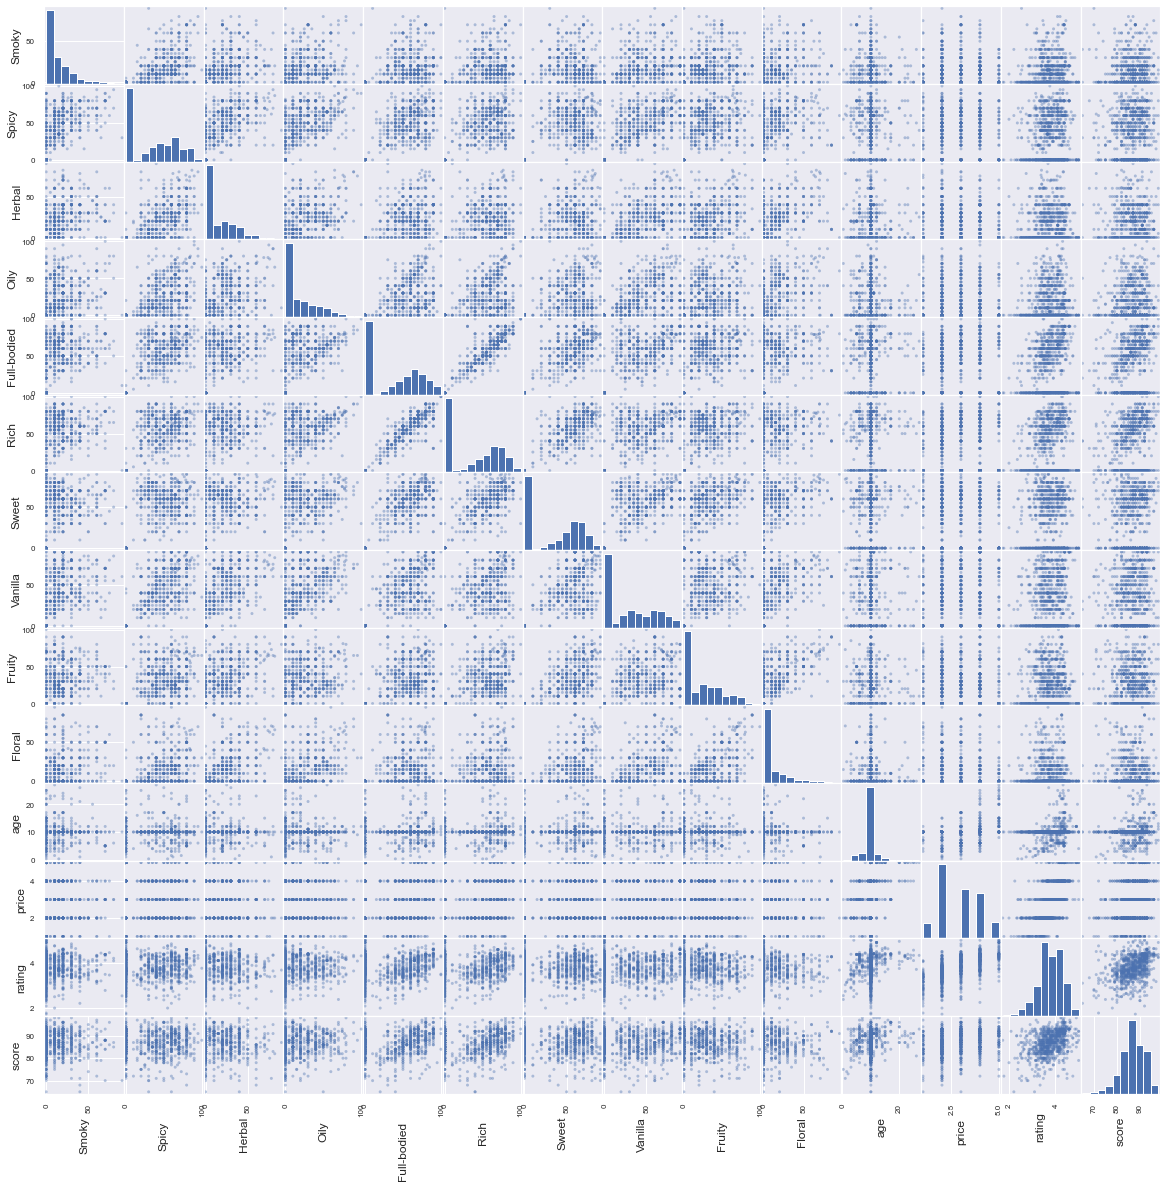

In [882]:
grid_features = ['Smoky', 'Spicy', 'Herbal', 'Oily', 'Full-bodied', 'Rich',
        'Sweet', 'Vanilla', 'Fruity', 'Floral', 
        'age', 'price', 'rating', 'score']

scatter = pd.plotting.scatter_matrix(df[grid_features], alpha=0.4, figsize=(20,20));
for ax in scatter.ravel():
    ax.set_xlabel(ax.get_xlabel(), rotation = 90)
    ax.set_ylabel(ax.get_ylabel(), rotation = 90)